In [12]:
import pandas as pd
import re
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from imblearn.over_sampling import RandomOverSampler
import torch.nn.functional as F
import os 

In [13]:
# ✅ 1. Load & Preprocess Data
script_dir = os.getcwd() # Ga één map omhoog om 'baseline' te verwijderen en ga naar 'Data'
project_root = os.path.dirname(script_dir)  # Dit verwijdert 'baseline' van het script_dir
data_folder = os.path.join(project_root, "Data")

# 1. Dataset inladen
file_path = os.path.join(data_folder, "Grote_data.xlsx")
df = pd.read_excel(file_path)

# Drop unnecessary columns
if "TXT_file_name" in df.columns:
    df = df.drop(columns=["TXT_file_name"])

# Handle missing values
df = df.dropna(subset=["question"])
df["context"].fillna("", inplace=True)

# Clean text
def clean_text(text):
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\b[a-z]\)\s+', ' ', text)
    text = re.sub(r'\b\d+\.\b', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df["clean_text"] = (df["context"] + " " + df["question"]).apply(clean_text)

# ✅ Now: drop rare themes using original theme names
theme_counts = df["theme"].value_counts()
valid_themes = theme_counts[theme_counts >= 2].index
df = df[df["theme"].isin(valid_themes)]

# ✅ Recompute label encoding AFTER filtering
unique_themes = list(df["theme"].unique())
theme_to_id = {theme: idx for idx, theme in enumerate(unique_themes)}
id_to_theme = {idx: theme for theme, idx in theme_to_id.items()}
df["theme_id"] = df["theme"].map(theme_to_id)

print("All theme_ids:", sorted(df["theme_id"].unique()))
print("num_labels:", df["theme_id"].nunique())


C:\Users\corne\AppData\Local\Temp\ipykernel_16464\1357053087.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["context"].fillna("", inplace=True)


All theme_ids: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36)]
num_labels: 37


In [14]:
# ✅ 5. Split Data into Train & Test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["clean_text"].tolist(), df["theme_id"].tolist(), test_size=0.2, random_state=42, stratify=df["theme_id"]
)

from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# Create a small DataFrame from train lists
train_df = pd.DataFrame({
    "clean_text": train_texts,
    "theme_id": train_labels
})

# Compute class counts and use median as balancing target
theme_counts = train_df["theme_id"].value_counts()
median_count = theme_counts.median()

# Define strategy: only oversample underrepresented classes
sampling_strategy = {
    theme: int(median_count)
    for theme in theme_counts.index
    if theme_counts[theme] < median_count
}

# Apply RandomOverSampler
ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = ros.fit_resample(train_df[["clean_text"]], train_df["theme_id"])

# Extract oversampled train lists
train_texts_resampled = X_resampled["clean_text"].tolist()
train_labels_resampled = y_resampled.tolist()

from collections import Counter
print("Class distribution after oversampling:", Counter(train_labels_resampled))


# ✅ 7. Load BERT Tokenizer & Define Dataset Class
model_name = "GroNLP/bert-base-dutch-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

class ThemeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx], padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt"
        )
        encoding["labels"] = torch.tensor(self.labels[idx])
        return {key: val.squeeze(0) for key, val in encoding.items()}

train_dataset = ThemeDataset(train_texts_resampled, train_labels_resampled, tokenizer)
test_dataset = ThemeDataset(test_texts, test_labels, tokenizer)

Class distribution after oversampling: Counter({15: 5147, 4: 1763, 9: 1699, 26: 1216, 12: 1124, 6: 949, 21: 860, 0: 855, 20: 736, 16: 641, 28: 622, 14: 612, 8: 553, 1: 527, 17: 433, 23: 332, 22: 330, 11: 323, 31: 253, 27: 253, 25: 253, 5: 253, 24: 253, 2: 253, 19: 253, 29: 253, 18: 253, 13: 253, 7: 253, 3: 253, 32: 253, 10: 253, 30: 253, 33: 253, 34: 253, 35: 253, 36: 253})


LOAD THE MODEL YOU WANT TO EVALUATE FROM KUL DRIVE!!

In [15]:
from transformers import BertForSequenceClassification, BertTokenizer

model_path = "C:/Users/corne/OneDrive - KU Leuven/Thesis/Working Code/SAVED-Models/ImprovedModelGroNLP(1-04)"

# Load model and tokenizer
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path).cuda()
print(model.config._name_or_path)


C:/Users/corne/OneDrive - KU Leuven/Thesis/Working Code/SAVED-Models/ImprovedModelGroNLP(1-04)


In [16]:
training_args = TrainingArguments(output_dir="./results", per_device_eval_batch_size=8)

trainer = Trainer(
    model=model,
    args=training_args
)

In [17]:
predictions = trainer.predict(test_dataset)


100%|██████████| 660/660 [01:30<00:00,  7.27it/s]


HANDLE UNKNOWNS and save those predictions

In [20]:
# ✅ 13. Make Predictions (With Dynamic Confidence Threshold & Short Question Handling)
probabilities = F.softmax(torch.tensor(predictions.predictions), dim=1)

# ✅ Dynamically Adjust the Confidence Threshold (1st Percentile)
confidence_values = torch.max(probabilities, dim=1)[0].tolist()
dynamic_threshold = np.percentile(confidence_values, 1)  # ✅ Set threshold at the 5th percentile
print(f"Dynamic Threshold: {dynamic_threshold}")  # ✅ Print the new threshold

# ✅ Predict Themes with "Unknown" for Unclear Questions
predicted_labels = []
for i in range(len(probabilities)):
    max_prob = torch.max(probabilities[i]).item()
    pred_label = torch.argmax(probabilities[i]).item()
    question_text = test_texts[i]

    # ✅ If question is too short and lacks context, assign "Unknown"
    if len(question_text.split()) < 4:
        predicted_labels.append("Unknown")
    elif max_prob < dynamic_threshold:
        predicted_labels.append("Unknown")  # ✅ Filter out low-confidence predictions
    else:
        predicted_labels.append(id_to_theme[pred_label])  # ✅ Assign label


Dynamic Threshold: 0.14663756802678107


In [ ]:
# ✅ 14. Save Predictions 
output_df = pd.DataFrame({
    "Text": test_texts,
    "True_Theme": [id_to_theme[label] for label in test_labels],
    "Predicted_Theme": predicted_labels
})


# output_df.to_excel("PAS NAAM AAN!! .xlsx", index=False)  !!! PAS NAAM AAN!!
print("✅ Model Training Completed! Predictions saved.")

EVALATION

In [23]:
unknown_count = predicted_labels.count("Unknown")
print(f"Unknown predictions: {unknown_count} / {len(predicted_labels)} ({unknown_count/len(predicted_labels)*100:.2f}%)")


Unknown predictions: 53 / 5278 (1.00%)


In [ ]:
y_pred = predictions.predictions.argmax(axis=1)
y_true = predictions.label_ids


from sklearn.metrics import classification_report

all_labels = sorted(id_to_theme.keys())  # [0, 1, 2, ..., 34]
all_names = [id_to_theme[i] for i in all_labels]

print(classification_report(y_true, y_pred, labels=all_labels, target_names=all_names))

                                                                     precision    recall  f1-score   support

                                              Vlaamse administratie       0.56      0.96      0.71       214
                                                            Cultuur       0.70      0.94      0.81       132
                                                   Vlaamse Regering       1.00      0.98      0.99        59
                                                      Armoedebeleid       0.86      0.96      0.91        26
                                                   Natuur en Milieu       0.92      0.92      0.92       440
                                                        Jeugdbeleid       0.86      0.86      0.86        56
                                                            Energie       0.98      0.87      0.92       237
                                               Ruimtelijke ordening       0.96      0.83      0.89        30
                  

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average="weighted")
recall = recall_score(true_labels, predicted_labels, average="weighted")
f1 = f1_score(true_labels, predicted_labels, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.9083
Precision: 0.9262
Recall: 0.9083
F1-Score: 0.9146


c:\Users\corne\anaconda3\envs\thesis-env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


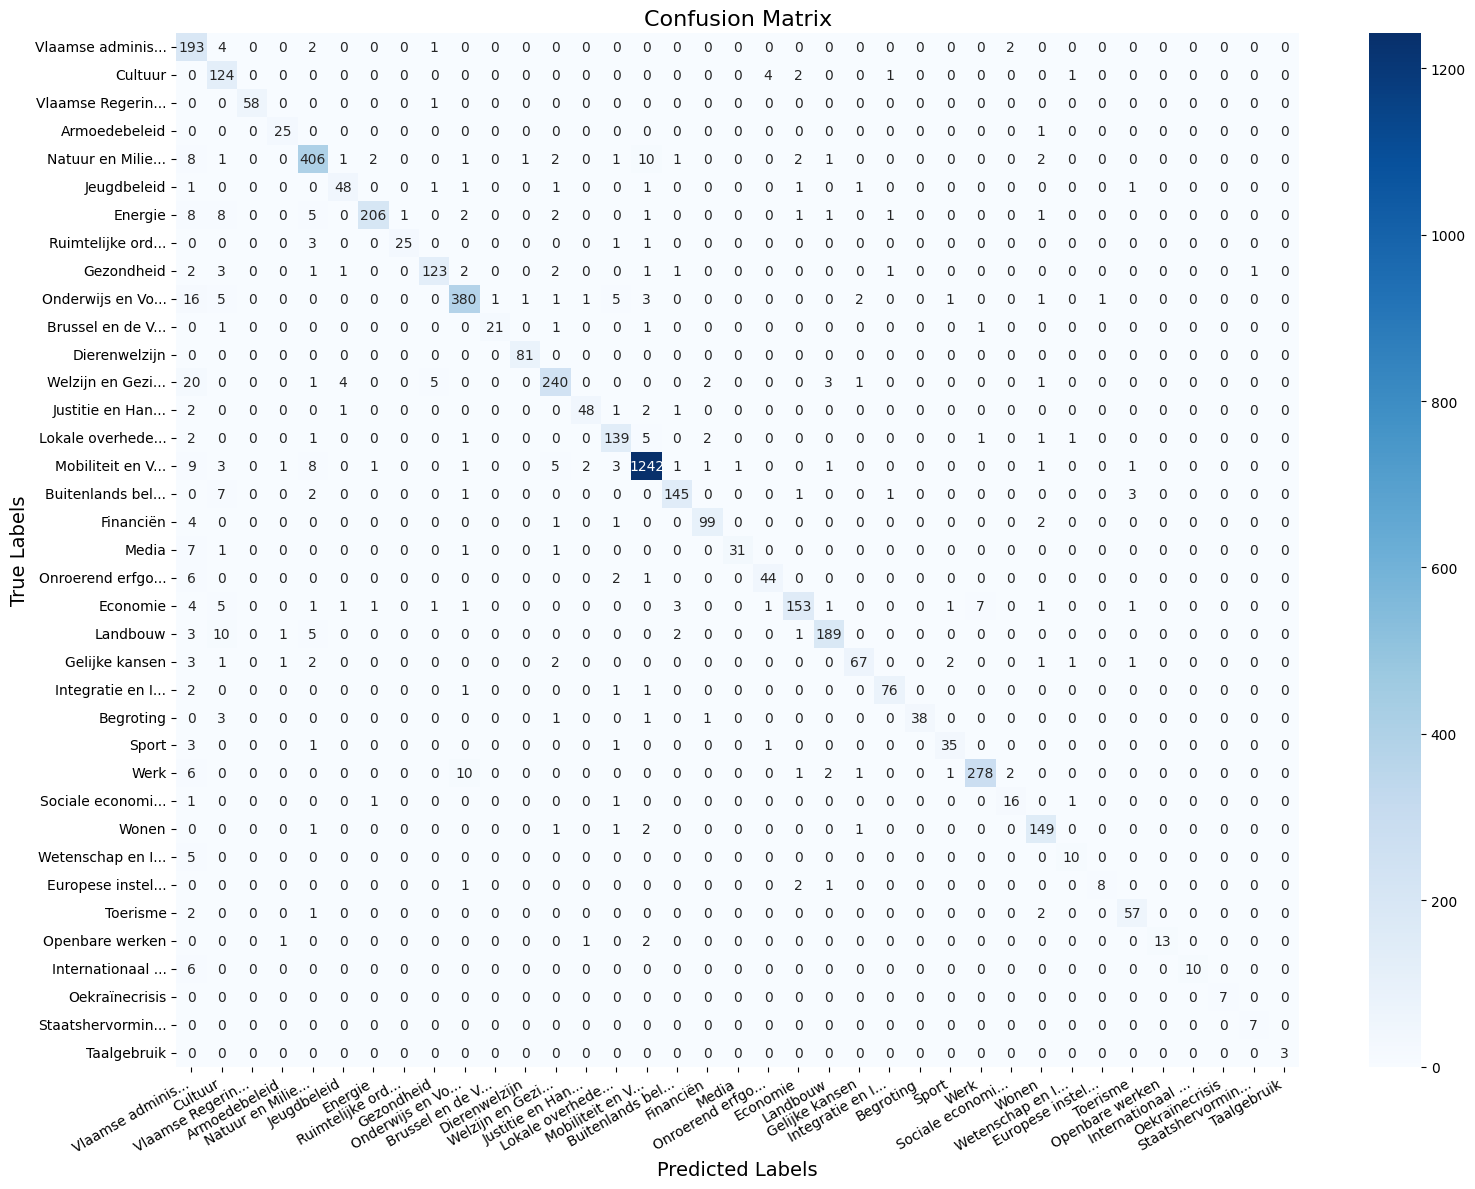

In [21]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
true_labels = [id_to_theme[label] for label in test_labels]
cm = confusion_matrix(true_labels, predicted_labels, labels=unique_themes)

# Shorten labels for better readability (optional)
short_labels = [label[:15] + "..." if len(label) > 15 else label for label in unique_themes]

# Plot confusion matrix as a heatmap
plt.figure(figsize=(16, 12))  # Increase figure size
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=short_labels, yticklabels=short_labels, cbar=True)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.xticks(rotation=30, ha="right", fontsize=10)  # Rotate x-axis labels slightly
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

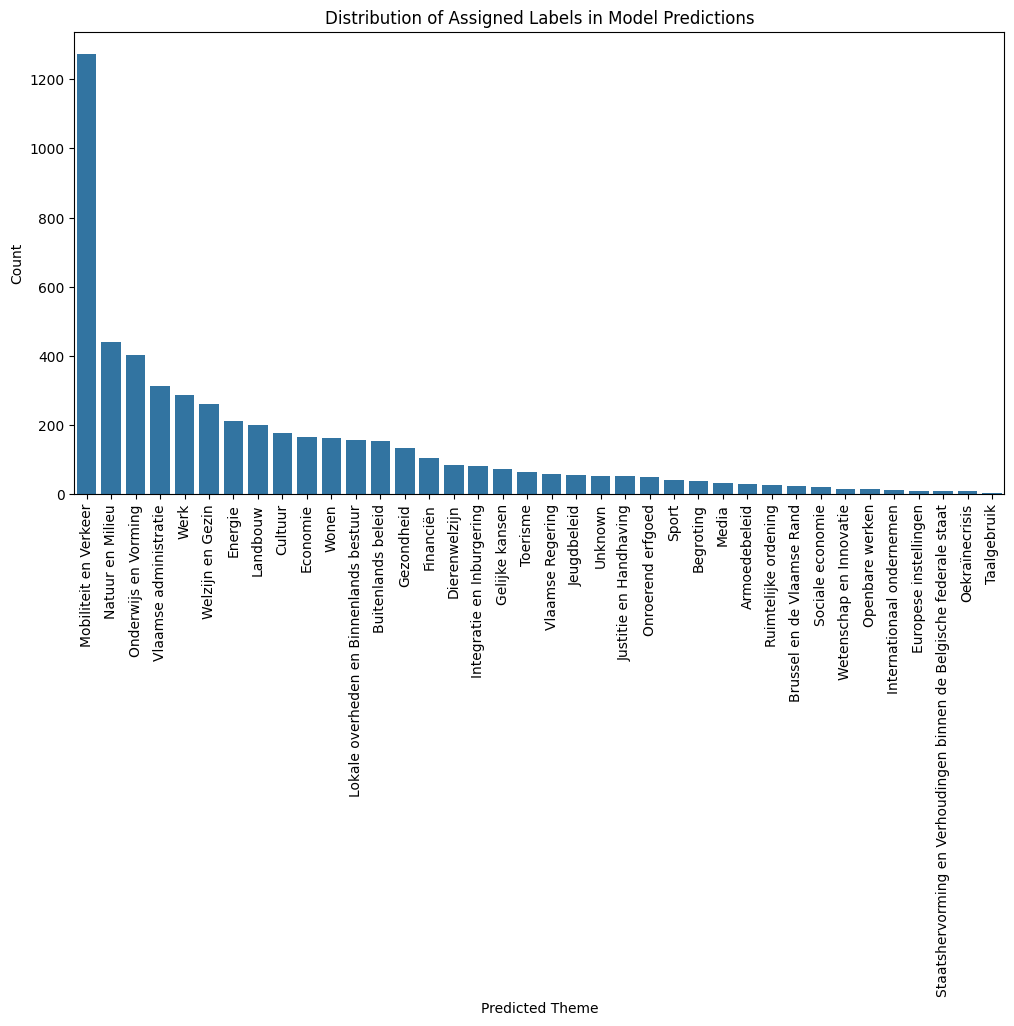

In [25]:
# ✅ 15. Visualize Distribution of Predicted Themes

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ✅ Replace this with your actual predictions DataFrame
# Example: If your predictions are stored in a variable `predicted_labels`
# Convert it into a DataFrame for visualization
df = pd.DataFrame({"Predicted_Theme": predicted_labels})

# ✅ Count occurrences of each predicted theme
label_counts = df["Predicted_Theme"].value_counts()

# ✅ Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xticks(rotation=90)
plt.xlabel("Predicted Theme")
plt.ylabel("Count")
plt.title("Distribution of Assigned Labels in Model Predictions")
plt.show()


In [27]:
import torch

# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", device)

Using device: cuda


In [28]:
def get_attention_and_prediction(clean_text):
    """Extracts attention scores and model prediction for a given question."""
    model.config.output_attentions = True  # Ensure attention is enabled

    # Tokenize input
    tokenizer_inputs = tokenizer(clean_text, return_tensors="pt")  
    tokenizer_inputs = {key: val.to(device) for key, val in tokenizer_inputs.items()}  # Move to GPU if available

    # Forward pass to get attention scores and logits
    with torch.no_grad():
        outputs = model(**tokenizer_inputs)

    attentions = outputs.attentions  # Extract attention scores
    logits = outputs.logits  # Model prediction scores

    predicted_class_id = logits.argmax(dim=1).item()  # Get predicted class ID
    predicted_class_name = id_to_theme.get(predicted_class_id, "Unknown")  # Convert ID to actual class name

    return attentions, predicted_class_id, predicted_class_name


test_question = "Hoeveel subsidies zijn toegekend aan bedrijven?"
attention_scores, predicted_class_id, predicted_class_name = get_attention_and_prediction(test_question)

print(f"✅ Model predicted class: {predicted_class_name} (ID: {predicted_class_id})")
print(f"🔍 Total Attention Layers Extracted: {len(attention_scores)}")

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


✅ Model predicted class: Economie (ID: 20)
🔍 Total Attention Layers Extracted: 12
